# Introduction

## Problem Statement
The deliverable would be to create a API which is capable of predicting and differentiating natural scenes into 6 categories namely: buildings,forest,glacier,mountain,sea and street.

## DataSet
For the dataset, Intel Image Classification Dataset will be used which contains around 25k images of size 150x150.

## Context

This Data contains around 25k images of size 150x150 distributed under 6 categories.
-  buildings = 0
-  forest = 1
-  glacier = 2
-  mountain = 3
-  sea = 4
-  street = 5 

### Import Necessary Libraries

In [1]:
import numpy as np #numeical calculations
import pandas as pd #data manipulation and analysis
import matplotlib.pyplot as plt #Chart Visualization
import os 
import torch # a deep learning framework that provides tools for building and training neural networks
import torchvision # ecosystem that provides datasets, model architectures, and image transformations
import torch.nn as nn # provides tools to define and manage neural network layers
import torch.nn.functional as F #provides functions used as layers in neural networks
from torchvision.transforms import ToTensor # to convert PIL or numpy arrays to tourch images
import torchvision.transforms as tt 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split #load data in batches
from torchvision.datasets import ImageFolder

### Preprocessing Data

##### Loading the data
- ImageFolder from PyTorch for loading datasets in standard format intended for computer vision
- It wil contain subdirectories for each and images under these subdirectories

##### Transform
- Specify transformation used on the images
- They include image edits such as:
  - fliping
  - scaling
  - normalization

##### Resizing Images
- Resize Images from 150x150 to 64 pixels

In [2]:
train = ImageFolder(
    "./Datasets/archive/seg_train/",
    transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor()
]))

##### DataLoader 
- Provides efficiency when dealing with larger datasets.
- Creates mini-batches of samples for training and evaluation

In [3]:
train_dl = DataLoader(
    train,
    64,
    shuffle=True,
    num_workers=3,
    pin_memory=True
)

# WHen pin memory is true dataloader will pin the images or data to the device memory before returning



##### Normalization 
Images will be normalized by subtrating the mean and dividing by the standard deviation across each channel. This is done s that mean accross each channel is 0 and standard deviation is 1. 

##### Goals of Normalization
- Reduce bias: ensure the model does not lean towards larger ranges.
- Achieve uniform gradient decent by reduing the images sizes uniformly 
- Overall more generalized to prvent the tendency of overfitting.


In [4]:
def get_mean_sum(dl):
    sum_, squared_sum, batches = 0,0,0 
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean, std

mean, std = get_mean_sum(train_dl)
mean, std    

(tensor([0.4301, 0.4574, 0.4539]), tensor([0.2481, 0.2467, 0.2806]))

##### Data Augmentation 
- increase the size of the dataset by creating more samples artificially
- apply chosen transformations while loading datasets
- take random crop of sizes 64 X 64 of images and flipping them horizontally with 50% propability

##### Goals of data Aumentaion
- display the images perspective will help the model generallize the images better for more efficient training.


In [5]:
stats = ((0.4304, 0.4576, 0.4540)), ((0.2483, 0.2468, 0.2807))

In [6]:
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

In [7]:
train = ImageFolder("./Datasets/archive/seg_train/seg_train/", transform=train_transform)
test = ImageFolder("./Datasets/archive/seg_test/seg_test/", transform= test_transform)

##### Spit Data into train and test sets 
##### Validation of Breaking Dataset
- Breaking  up the datasets provides a better proficient model as getting better performance on reapeat data is not practical.
- The model trains on one set and is tested on a completly different images


In [8]:
random_seed = 42
torch.manual_seed(random_seed)

###### manual_seed 
- function used to set random_seed onto Pytorch random number generator.
- random_seed ensure to avoid variance when traiing data

In [9]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size,val_size])
len(train_ds), len(val_ds)

(11228, 2806)

In [10]:
len(train) * 0.2

2806.8

Creating data loaders for retrieving images in batches. Batch size can be configured if "out of memory" err comes up

In [11]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

###### Display Images 
- Denormalize the pixels values and bring them back to (0,1)

In [12]:
def denormalize(images, means, stds):
    means= torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means 

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

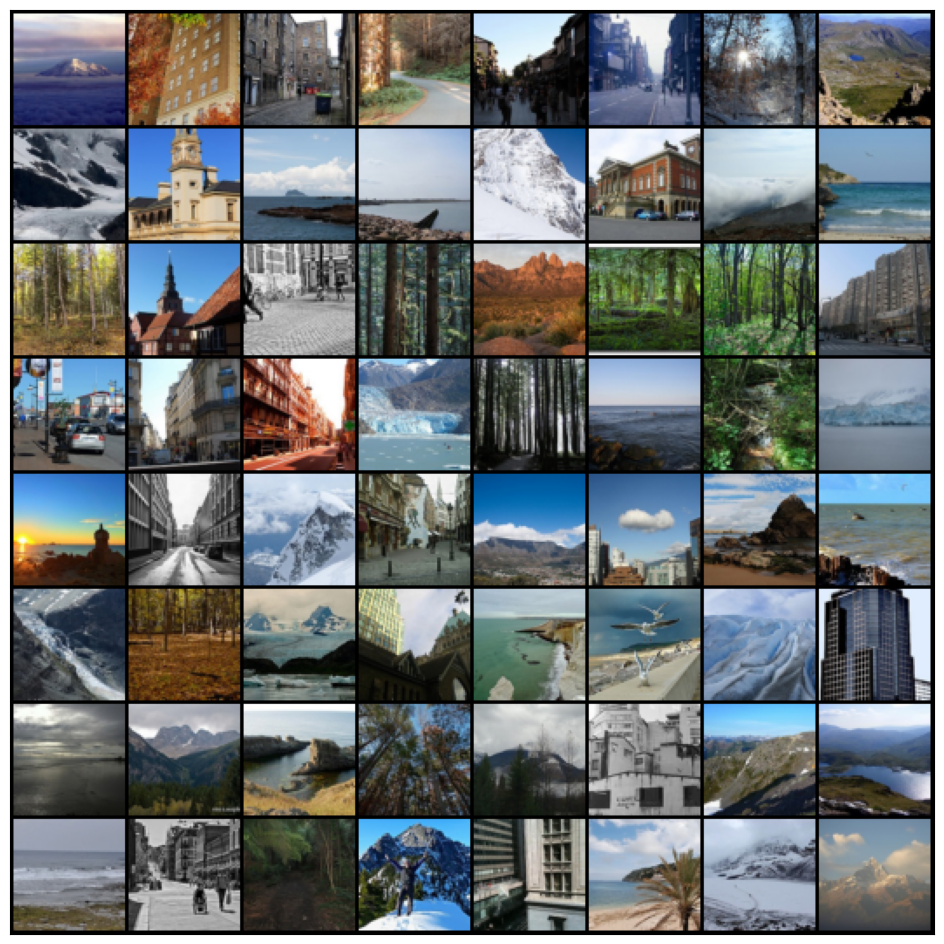

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True) 



In [15]:
class DeviceDataLoader():
    def __init__(self, dl, device): 
        self.dl = dl
        self.device = device 

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [16]:
get_default_device()

device(type='cuda')

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss 

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']
        ))

#### Moving to GPU

In [44]:
device = get_default_device()
device 

device(type='cuda')

In [45]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Building Model

## Model Architecture

The model is built using a custom ResNet9 architecture, which includes:
- **Convolutional Layers**: Used for feature extraction.
- **Residual Connections**: Helps in training deeper networks by preventing vanishing gradients.
- **Fully Connected Layer**: Final classification layer with 6 outputs corresponding to the 6 categories.

In [46]:
# Creating CNN
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



In [47]:
class ResNet9(ImageClassificationBase): 
    def __init__(self, in_channels, num_classes): 
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Example loss calculation
# Number of classes in your dataset
num_classes = 6

# Instantiate the model
model = ResNet9(3, num_classes)  # Assuming the input images have 3 channels (RGB)

# Move the model to the appropriate device (CPU/GPU)
model = to_device(model, device)

# Example batch of images and labels
images, labels = next(iter(train_dl))  # Fetch a batch from the data loader

# Move images and labels to the device
images = to_device(images, device)
labels = to_device(labels, device)

# Get the model's predictions
out = model(images)

# Print the shapes of output and labels
print(out.shape, labels.shape)

# Calculate the loss
loss = F.cross_entropy(out, labels)

torch.Size([128, 6]) torch.Size([128])


In [48]:
 no_of_classes =  len(train.classes)

In [49]:
model = to_device( ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training and Validation

### Training Process
- **Optimizer**: Used SGD with a learning rate scheduler (OneCycleLR).
- **Loss Function**: Cross-Entropy Loss for multi-class classification.
- **Training Epochs**: Trained for `10` epochs.

### Validation
- Split the dataset into training and validation sets.
- **Validation Metrics**: Accuracy and loss are calculated for each epoch.

In [50]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs= [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']






In [51]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Create the optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up the OneCycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_loader:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping (if provided)
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Update model parameters
            optimizer.step()
            optimizer.zero_grad()
            
            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Evaluate the model on validation data
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [52]:
%%time
history = fit_one_cycle(
    epochs=10,         # Number of epochs to train
    max_lr=0.01,       # Maximum learning rate
    model=model,       # Your ResNet9 model
    train_loader=train_dl,  # Training DataLoader
    val_loader=valid_dl,    # Validation DataLoader
    weight_decay=1e-4,      # Weight decay for regularization
    grad_clip=0.1,          # Gradient clipping value
    opt_func=torch.optim.Adam  # Optimizer function
)


Epoch [0], last_lr: 0.00277, train_loss: 1.0278, val_loss: 0.8716, val_acc: 0.7066
Epoch [1], last_lr: 0.00758, train_loss: 0.7976, val_loss: 0.8831, val_acc: 0.6927
Epoch [2], last_lr: 0.01000, train_loss: 0.8260, val_loss: 0.9726, val_acc: 0.6596
Epoch [3], last_lr: 0.00950, train_loss: 0.6717, val_loss: 0.6245, val_acc: 0.7880
Epoch [4], last_lr: 0.00812, train_loss: 0.5311, val_loss: 0.4996, val_acc: 0.8160
Epoch [5], last_lr: 0.00611, train_loss: 0.4432, val_loss: 0.5398, val_acc: 0.8043
Epoch [6], last_lr: 0.00389, train_loss: 0.3968, val_loss: 0.3673, val_acc: 0.8673
Epoch [7], last_lr: 0.00188, train_loss: 0.3068, val_loss: 0.3384, val_acc: 0.8865
Epoch [8], last_lr: 0.00050, train_loss: 0.2614, val_loss: 0.3174, val_acc: 0.8905
Epoch [9], last_lr: 0.00000, train_loss: 0.2241, val_loss: 0.3128, val_acc: 0.8937
CPU times: total: 32min 56s
Wall time: 2h 35min 22s


In [55]:
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()
    test_results = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(test_results)

# Evaluate the model on the test set
test_results = test_model(model, test_dl)
print(test_results)

{'val_loss': 0.29031211137771606, 'val_acc': 0.8997254371643066}


### Evaluation 
- The traing set was broken into two parts training set and validation set which is used to test the model before testing it on the testing set.
- Model started off at val_loss: 0.87 and val_acc: 0.70
- upon 10 epochs, validation loss reached to 0.29(lower the better)
- val_acc however is at 0.8997 or 89.97% accurate on validation set

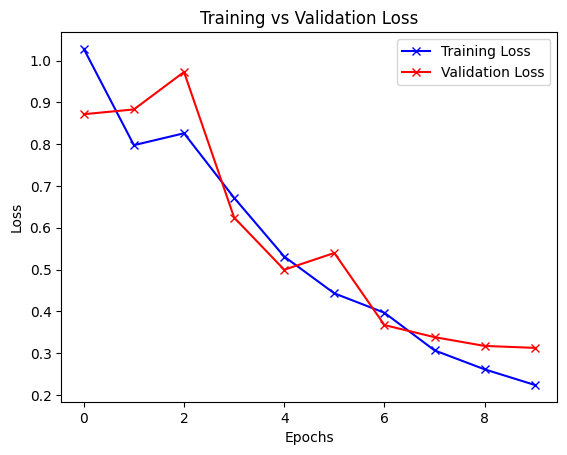

In [56]:
def plot_loss(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Training vs Validation Loss')
    plt.show()

plot_loss(history)

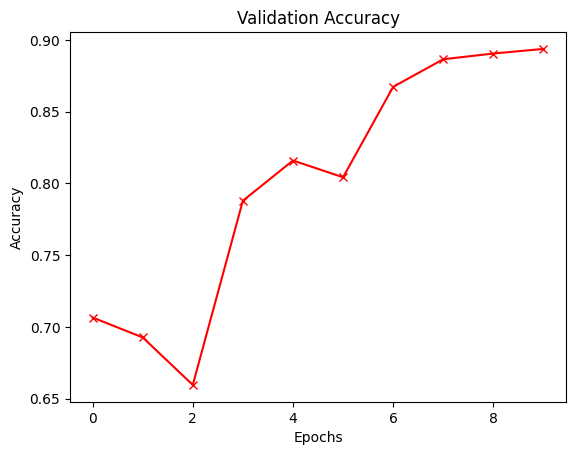

In [57]:
def plot_accuracy(history):
    val_accs = [x['val_acc'] for x in history]
    plt.plot(val_accs, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.show()

plot_accuracy(history)

### Chart Evaluation
- training and validation loss are compared in the line graph above. This displays the cases of overfitting(increse in val_loss)
- Second chart display the case for observing the model training proces


### Summary:
- Your model started with higher losses and lower accuracy, which is normal. Over the epochs, the training loss decreased, and the validation accuracy improved, indicating the model learned the task well.
- By the final epoch, the model achieves strong performance, with a validation accuracy close to 89.37% and a low validation loss.
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [2]:
import torch
torch.save(model.state_dict(), 'intel_image_classifier.pth')

NameError: name 'model' is not defined